# Predicting the condition of water wells in Tanzania

<img src="./images/water_fill.jpg" 
     align="left" 
     width="400" />

### Data Preparation

In [1]:
#Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
#Loading data
test_set_values = pd.read_csv('Data/test_set_values.csv')
training_set_labels = pd.read_csv('Data/training_set_labels.csv')
training_set_values = pd.read_csv('Data/training_set_values.csv')

#### Merging training set values and training set labels 

In [3]:
#inner merge
training_all = pd.merge(training_set_values, training_set_labels, on='id', how='inner')

In [4]:
training_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Data Cleaning - dealing with N/A values and removing unnecessary data columns

In [5]:
training_all.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [6]:
#Dropping the num_private column because there is no data on what this column means on the website source of the data
training_all.drop(columns='num_private', inplace=True)

In [7]:
# Replace specific values in the 'installer' column
training_all['installer'] = training_all['installer'].replace('Hesawa', 'HESAWA')
training_all['installer'] = training_all['installer'].replace('DANID', 'DANIDA')
training_all['installer'] = training_all['installer'].replace('Commu', "Community")

In [8]:
#changing the name of some the columns so they are more intuitive
training_all.rename(columns={'gps_height': 'well_altitude'}, inplace=True)
training_all.rename(columns={'wpt_name': 'water_point_name'}, inplace=True)
training_all.rename(columns={'payment': 'payment_type'}, inplace=True)
training_all.rename(columns={'payment_type': 'frequency_of_payment'}, inplace=True)
training_all.rename(columns={'funder': 'funding_source'}, inplace=True)

In [9]:
# Changing three options for functioning status of wells to two options - functional or needing repair
to_replace = ['functional needs repair']
new_value = 'functional'
training_all['status_group'] = training_all['status_group'].replace(to_replace, new_value)

In [10]:
training_all.dropna(subset=['latitude'], inplace=True)
training_all.dropna(subset=['longitude'], inplace=True)
training_all = training_all.loc[training_all['longitude'] != 0]
training_all = training_all.loc[training_all['latitude'] != 0]

## Data Cleaning by each variable

### Construction year

In [11]:
#Drop rows with construction year of 0
training_all.drop(training_all[training_all['construction_year'] == 0].index, inplace=True)
training_all['construction_year'].value_counts()

2010    2645
2008    2613
2009    2533
2000    2091
2007    1587
2006    1471
2003    1286
2011    1256
2004    1123
2012    1084
2002    1075
1978    1037
1995    1014
2005    1011
1999     979
1998     966
1990     954
1985     945
1996     811
1980     811
1984     779
1982     744
1994     738
1972     708
1974     676
1997     644
1992     640
1993     608
2001     540
1988     521
1983     488
1975     437
1986     434
1976     414
1970     411
1991     324
1989     316
1987     302
1981     238
1977     202
1979     192
1973     184
2013     176
1971     145
1960     102
1967      88
1963      85
1968      77
1969      59
1964      40
1962      30
1961      21
1965      19
1966      17
Name: construction_year, dtype: int64

### Installer

In [12]:
#For installer, filter out those with less than 500 count

In [13]:
# Calculate installer counts
installer_counts = training_all['installer'].value_counts()

# Identify installers with counts >= 500
installers_to_keep = installer_counts[installer_counts >= 500].index

# Filter the DataFrame based on installers to keep
training_all = training_all[training_all['installer'].isin(installers_to_keep)]

In [14]:
training_all.head()

,id,amount_tsh,date_recorded,funding_source,well_altitude,installer,longitude,latitude,water_point_name,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,Pangani,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
11,50409,200.0,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,Lake Nyasa,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
15,61848,0.0,2011-08-04,Rudep,1645,DWE,31.444121,-8.274962,Kwa Juvenal Ching'Ombe,Lake Tanganyika,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
16,48451,500.0,2011-07-04,Unicef,1703,DWE,34.642439,-9.106185,Kwa John Mtenzi,Rufiji,...,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional
17,58155,0.0,2011-09-04,Unicef,1656,DWE,34.569266,-9.085515,Kwa Rose Chaula,Rufiji,...,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional


### Scheme management

In [15]:
# drop n/a
training_all.dropna(subset=['scheme_management'], inplace=True)

In [16]:
# drop "None" and "Other" values
training_all = training_all.loc[training_all['scheme_management'] != 'None']
training_all = training_all.loc[training_all['scheme_management'] != 'Other']

### Extraction type

In [17]:
training_all['extraction_type'].value_counts()

gravity                      10671
other                         1281
submersible                   1138
swn 80                         891
nira/tanira                    778
india mark ii                  528
mono                           348
afridev                        274
ksb                            122
other - swn 81                  44
india mark iii                   6
other - rope pump                6
other - play pump                3
other - mkulima/shinyanga        1
windmill                         1
Name: extraction_type, dtype: int64

In [18]:
# overwhelming majority of pumps have gravity as extraction type, so maybe not worth it to filter

In [19]:
# Extraction type class makes more sense, seems more organized into extraction types that could be compared, 
# but still most pumps use gravity extraction method
training_all['extraction_type_class'].value_counts()

gravity         10671
handpump         2525
other            1281
submersible      1260
motorpump         348
rope pump           6
wind-powered        1
Name: extraction_type_class, dtype: int64

### Management or management group

In [20]:
training_all['management'].value_counts()

vwc                 11467
water board          1466
wug                  1102
wua                   813
private operator      383
parastatal            338
water authority       323
other - school         99
other                  52
unknown                26
trust                  13
company                10
Name: management, dtype: int64

In [21]:
training_all['management_group'].value_counts()

user-group    14848
commercial      729
parastatal      338
other           151
unknown          26
Name: management_group, dtype: int64

### Quantity

In [22]:
training_all['quantity'].value_counts()

enough          9897
insufficient    4044
dry             1354
seasonal         666
unknown          131
Name: quantity, dtype: int64

In [23]:
training_all['quantity_group'].value_counts()

enough          9897
insufficient    4044
dry             1354
seasonal         666
unknown          131
Name: quantity_group, dtype: int64

In [24]:
# drop quantity_group column because it is a duplicate of quantity column 
training_all.drop(columns='quantity_group', inplace=True)

In [25]:
# drop unknown values from quantity column
training_all = training_all.loc[training_all['quantity'] != 'unknown']

### Source

In [26]:
training_all['source'].value_counts()

spring                  6861
river                   3703
shallow well            2366
machine dbh             2228
lake                     208
hand dtw                 188
rainwater harvesting     176
other                    123
dam                       93
unknown                   15
Name: source, dtype: int64

In [27]:
# drop unknown values from quantity column
training_all = training_all.loc[training_all['source'] != 'unknown']
training_all = training_all.loc[training_all['source'] != 'other']

### Waterpoint type

In [28]:
training_all['waterpoint_type'].value_counts()

communal standpipe             9850
hand pump                      2749
communal standpipe multiple    1570
other                          1407
improved spring                 206
cattle trough                    37
dam                               4
Name: waterpoint_type, dtype: int64

In [29]:
training_all['waterpoint_type_group'].value_counts()

communal standpipe    11420
hand pump              2749
other                  1407
improved spring         206
cattle trough            37
dam                       4
Name: waterpoint_type_group, dtype: int64

In [30]:
training_all['status_group'].value_counts()

functional        10237
non functional     5586
Name: status_group, dtype: int64

## Preliminary analysis

### Installer

In [31]:
# Replace 'installer' with the actual column name
installer_counts = training_all['installer'].value_counts()

# Get installer types with less than 2 instances
installers_to_remove = installer_counts[installer_counts < 500].index

# Filter the dataset to exclude rows with those installer types
installer_filtered = training_all[~training_all['installer'].isin(installers_to_remove)]

In [32]:
installer_filtered = installer_filtered.loc[installer_filtered['installer'] != '0']

In [33]:
installer_filtered['installer'].value_counts()

DWE           9558
DANIDA        1314
Community     1115
Government     958
RWE            905
TCRS           617
CES            610
Name: installer, dtype: int64

In [34]:
installer_dummy = pd.get_dummies(installer_filtered, columns=['installer'], prefix='installer')
installer_dummy.head()

,id,amount_tsh,date_recorded,funding_source,well_altitude,longitude,latitude,water_point_name,basin,subvillage,...,waterpoint_type,waterpoint_type_group,status_group,installer_CES,installer_Community,installer_DANIDA,installer_DWE,installer_Government,installer_RWE,installer_TCRS
11,50409,200.0,2013-02-18,Danida,1062,35.770258,-10.574175,Kwa Alid Nchimbi,Lake Nyasa,Ngondombwito,...,hand pump,hand pump,functional,0,0,1,0,0,0,0
15,61848,0.0,2011-08-04,Rudep,1645,31.444121,-8.274962,Kwa Juvenal Ching'Ombe,Lake Tanganyika,Tunzi,...,hand pump,hand pump,functional,0,0,0,1,0,0,0
16,48451,500.0,2011-07-04,Unicef,1703,34.642439,-9.106185,Kwa John Mtenzi,Rufiji,Kidudumo,...,communal standpipe,communal standpipe,non functional,0,0,0,1,0,0,0
17,58155,0.0,2011-09-04,Unicef,1656,34.569266,-9.085515,Kwa Rose Chaula,Rufiji,Yeriko,...,communal standpipe,communal standpipe,non functional,0,0,0,1,0,0,0
22,58500,0.0,2011-10-04,Unicef,1510,34.586901,-8.980014,Shuleni,Rufiji,Mkanivega,...,communal standpipe,communal standpipe,functional,0,0,0,1,0,0,0


In [35]:
installer_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15077 entries, 11 to 59395
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     15077 non-null  int64  
 1   amount_tsh             15077 non-null  float64
 2   date_recorded          15077 non-null  object 
 3   funding_source         15073 non-null  object 
 4   well_altitude          15077 non-null  int64  
 5   longitude              15077 non-null  float64
 6   latitude               15077 non-null  float64
 7   water_point_name       15077 non-null  object 
 8   basin                  15077 non-null  object 
 9   subvillage             15075 non-null  object 
 10  region                 15077 non-null  object 
 11  region_code            15077 non-null  int64  
 12  district_code          15077 non-null  int64  
 13  lga                    15077 non-null  object 
 14  ward                   15077 non-null  object 
 15  p

In [36]:
# model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the dataset into features (X) and target (y)
X = installer_dummy[['installer_CES', 'installer_Community', 'installer_DANIDA', 'installer_DWE', 'installer_Government', 'installer_RWE', 'installer_TCRS']]  # Drop the target column
y = installer_dummy['status_group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.66


## Construction year

In [37]:
year = training_all[['status_group','construction_year']]

In [38]:
year.drop(year[year['construction_year'] == 0].index, inplace=True)

C:\Users\emily\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
year['construction_year'].value_counts()

2008    1149
2000     901
2010     825
2009     798
1978     708
1999     559
1995     543
2007     542
1990     490
2006     451
1974     424
1992     409
1972     406
1985     402
1984     395
2002     380
1994     339
1998     339
1980     338
1993     336
2003     325
1983     308
2005     303
1982     295
2004     275
1976     262
1997     260
1970     256
1996     256
1988     234
2012     223
1986     217
2011     200
1975     199
1989     189
1991     179
1987     153
2001     121
1981     104
1973      93
1977      85
1963      80
1979      79
1971      79
1967      73
2013      55
1969      51
1968      37
1964      34
1960      23
1961      13
1962      11
1966       9
1965       8
Name: construction_year, dtype: int64

In [40]:
year['construction_year'].describe()

count    15823.000000
mean      1993.844341
std         12.917642
min       1960.000000
25%       1983.000000
50%       1996.000000
75%       2006.000000
max       2013.000000
Name: construction_year, dtype: float64

In [41]:
# Assuming your DataFrame is named 'data' and the column to convert is 'status_group'
year['status_group'] = year['status_group'].map({'functional': 1, 'non functional': 0})

<ipython-input-41-437b921115cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year['status_group'] = year['status_group'].map({'functional': 1, 'non functional': 0})


In [42]:
import statsmodels.api as sm

# Assuming you have a DataFrame named 'data' with columns 'year' and 'status_group'
# 'status_group' should be encoded as 0 (not functional) and 1 (functional)

# Create a constant term to include in the model
year['constant'] = 1

# Define the independent variable (X) and dependent variable (y)
X = year[['constant', 'construction_year']]
y = year['status_group']

# Fit the logistic regression model
model = sm.Logit(y, X).fit()

# Print the summary of the regression
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.619532
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           status_group   No. Observations:                15823
Model:                          Logit   Df Residuals:                    15821
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Aug 2023   Pseudo R-squ.:                 0.04585
Time:                        13:49:16   Log-Likelihood:                -9802.9
converged:                       True   LL-Null:                       -10274.
Covariance Type:            nonrobust   LLR p-value:                6.888e-207
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
constant            -79.1793      2.659    -29.776      0.000     -84.391     -73.967
construc

<ipython-input-42-f919cf15ebc4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year['constant'] = 1


In [43]:
predicted_values = model.predict(X)
residuals = y - predicted_values

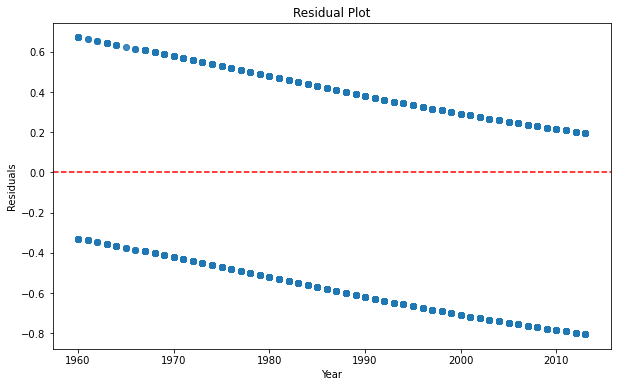

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X['construction_year'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [45]:
# Generate a range of years for prediction
years_for_prediction = np.arange(year['construction_year'].min(), year['construction_year'].max() + 1)

# Create a new DataFrame for prediction
prediction_data = pd.DataFrame({'constant': 1, '_construction_year': years_for_prediction})

# Calculate predicted probabilities for each year
predicted_probs = model.predict(prediction_data)

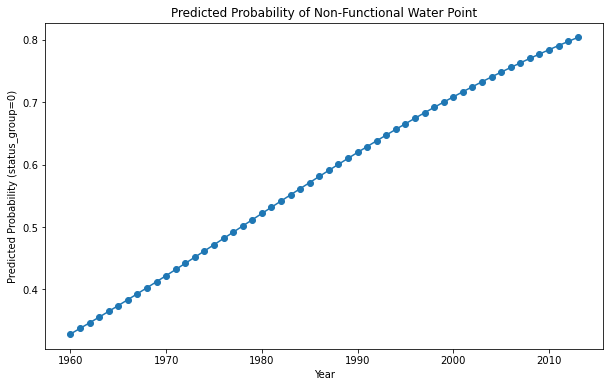

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(years_for_prediction, predicted_probs, marker='o')
plt.xlabel('Year')
plt.ylabel('Predicted Probability (status_group=0)')
plt.title('Predicted Probability of Non-Functional Water Point')
plt.show()

### Chi squared test

In [47]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chi2

alpha = 0.05
# List of variables to test
categorical_vars = ['waterpoint_type', 'installer', 'scheme_management', 'construction_year', 'extraction_type', 'management', 'quantity', 'source']

for var in categorical_vars:
    contingency_table = pd.crosstab(training_all['status_group'], training_all[var])
    
   
    degrees_of_freedom = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)
    
    # chi^2 test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    if chi2_stat > critical_value:
        print(f"{var} and target are dependent")
    else:
        print(f"{var} and target are independent")


waterpoint_type and target are dependent
installer and target are dependent
scheme_management and target are dependent
construction_year and target are dependent
extraction_type and target are dependent
management and target are dependent
quantity and target are dependent
source and target are dependent


In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X = training_all[['waterpoint_type', 'installer', 'scheme_management', 'construction_year', 'extraction_type', 'management', 'quantity', 'source']]
y = training_all['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_features = encoder.fit_transform(X_train[['waterpoint_type', 'installer', 'scheme_management', 'extraction_type', 'management', 'quantity', 'source']])

In [50]:
X_train_numeric = X_train[['construction_year']]
X_train_encoded = np.concatenate((X_train_numeric, encoded_features), axis=1)

In [51]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

In [52]:
encoded_features_test = encoder.transform(X_test[['waterpoint_type', 'installer', 'scheme_management', 'extraction_type', 'management', 'quantity', 'source']])

In [53]:
X_test_numeric = X_test[['construction_year']]
X_test_encoded = np.concatenate((X_test_numeric, encoded_features_test), axis=1)

In [54]:
y_pred = rf_model.predict(X_test_encoded)

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)

In [56]:
print("Accuracy:", accuracy)
print(" ")
print(report)
print(" ")
print("Confusion matrix:")
print(confusion_matrix)

Accuracy: 0.837914691943128
 
                precision    recall  f1-score   support

    functional       0.84      0.92      0.88      1998
non functional       0.83      0.70      0.76      1167

      accuracy                           0.84      3165
     macro avg       0.84      0.81      0.82      3165
  weighted avg       0.84      0.84      0.83      3165

 
Confusion matrix:
[[1835  163]
 [ 350  817]]


In [75]:
feature_importances = rf_model.feature_importances_


In [80]:
X_train

,waterpoint_type,installer,scheme_management,construction_year,extraction_type,management,quantity,source
29462,other,RWE,VWC,1976,gravity,vwc,insufficient,spring
25387,other,DWE,WUG,1986,other,wug,enough,shallow well
21783,communal standpipe multiple,Government,Water authority,2011,submersible,private operator,insufficient,machine dbh
49706,other,DWE,VWC,1972,gravity,vwc,insufficient,spring
50699,communal standpipe,TCRS,VWC,1980,gravity,vwc,enough,spring
...,...,...,...,...,...,...,...,...
50293,other,DWE,Parastatal,1998,gravity,parastatal,enough,spring
20532,communal standpipe,DWE,VWC,2000,gravity,vwc,insufficient,spring
3242,communal standpipe,DWE,VWC,2002,gravity,vwc,enough,river
59326,communal standpipe,DWE,VWC,1972,gravity,vwc,enough,spring


In [81]:
# Get feature names
feature_names = X_train.columns

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))


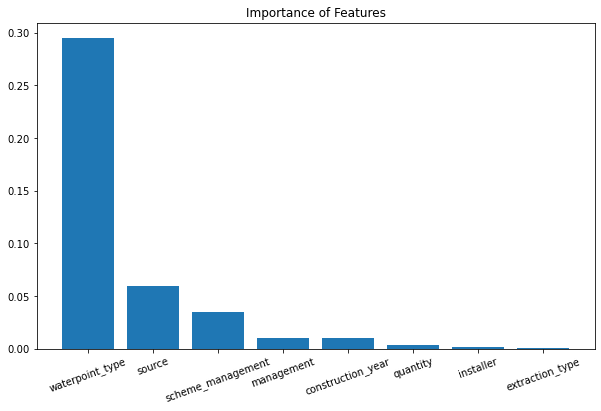

In [87]:
import matplotlib.pyplot as plt

# Sort feature importance dictionary by values
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importances
sorted_feature_names = [item[0] for item in sorted_importances]
sorted_importance_values = [item[1] for item in sorted_importances]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance_values)), sorted_importance_values, tick_label=sorted_feature_names)
plt.title("Importance of Features")
plt.xticks(rotation=20)
plt.show()


In [89]:
contingency_table = pd.crosstab(training_all['waterpoint_type'], training_all['status_group'])


In [95]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

## Decision tree

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_encoded, y_train)


DecisionTreeClassifier(random_state=42)

In [65]:
y_pred = dt_model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8303317535545024
Classification Report:
                 precision    recall  f1-score   support

    functional       0.83      0.93      0.87      1998
non functional       0.84      0.67      0.74      1167

      accuracy                           0.83      3165
     macro avg       0.83      0.80      0.81      3165
  weighted avg       0.83      0.83      0.83      3165

Confusion Matrix:
 [[1851  147]
 [ 390  777]]


In [66]:
## Gradient boosting model

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_encoded, y_train)


GradientBoostingClassifier(random_state=42)

y_pred = gb_model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


In [74]:
# This model has a lower accuracy score

## Individual variables

#### Waterpoint type

In [98]:
waterpoint_type_subset = training_all[['id', 'waterpoint_type', 'status_group']]

In [99]:
waterpoint_type_subset.head()

,id,waterpoint_type,status_group
11,50409,hand pump,functional
15,61848,hand pump,functional
16,48451,communal standpipe,non functional
17,58155,communal standpipe,non functional
22,58500,communal standpipe,functional


In [101]:
contingency_table = pd.crosstab(waterpoint_type_subset['waterpoint_type'], waterpoint_type_subset['status_group'])
print(contingency_table)


status_group                 functional  non functional
waterpoint_type                                        
cattle trough                        30               7
communal standpipe                 7280            2570
communal standpipe multiple         920             650
dam                                   3               1
hand pump                          1614            1135
improved spring                     191              15
other                               199            1208


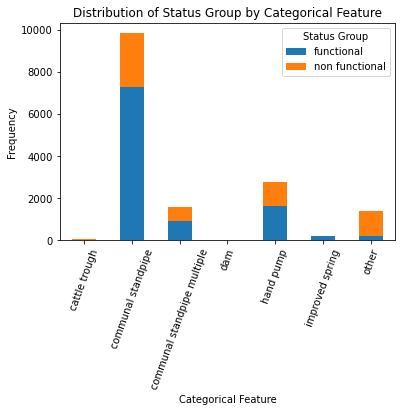

In [107]:
import matplotlib.pyplot as plt

contingency_table.plot(kind='bar', stacked=True)
plt.title('Distribution of Status Group by Categorical Feature')
plt.xlabel('Categorical Feature')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.legend(title='Status Group')
plt.show()

#### Source

In [110]:
source_subset = training_all[['id', 'source', 'status_group']]

In [111]:
contingency_table = pd.crosstab(source_subset['source'], source_subset['status_group'])
print(contingency_table)

status_group          functional  non functional
source                                          
dam                           56              37
hand dtw                      82             106
lake                          26             182
machine dbh                 1199            1029
rainwater harvesting         126              50
river                       2645            1058
shallow well                1094            1272
spring                      5009            1852


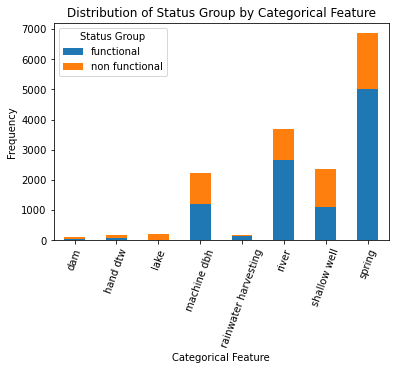

In [112]:
import matplotlib.pyplot as plt

contingency_table.plot(kind='bar', stacked=True)
plt.title('Distribution of Status Group by Categorical Feature')
plt.xlabel('Categorical Feature')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.legend(title='Status Group')
plt.show()

In [113]:
import scipy.stats as stats

# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:", expected)


Chi-squared: 1038.5407230257135
P-value: 5.6590938429530335e-220
Degrees of Freedom: 7
Expected Frequencies: [[  60.16817291   32.83182709]
 [ 121.63028503   66.36971497]
 [ 134.56967705   73.43032295]
 [1441.4482715   786.5517285 ]
 [ 113.86664981   62.13335019]
 [2395.72843329 1307.27156671]
 [1530.73007647  835.26992353]
 [4438.85843393 2422.14156607]]


In [115]:
# Create dummy variables for categorical predictor
dummy_columns = pd.get_dummies(waterpoint_type_subset['waterpoint_type'], prefix='waterpoint_type', drop_first=True)

# Combine dummy columns with original data
data_with_dummies = pd.concat([waterpoint_type_subset, dummy_columns], axis=1)

# Define the outcome variable (1: functional, 0: non-functional)
data_with_dummies['functional'] = (data_with_dummies['status_group'] == 'functional').astype(int)



In [116]:
data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15823 entries, 11 to 59395
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   id                                           15823 non-null  int64 
 1   waterpoint_type                              15823 non-null  object
 2   status_group                                 15823 non-null  object
 3   waterpoint_type_communal standpipe           15823 non-null  uint8 
 4   waterpoint_type_communal standpipe multiple  15823 non-null  uint8 
 5   waterpoint_type_dam                          15823 non-null  uint8 
 6   waterpoint_type_hand pump                    15823 non-null  uint8 
 7   waterpoint_type_improved spring              15823 non-null  uint8 
 8   waterpoint_type_other                        15823 non-null  uint8 
 9   functional                                   15823 non-null  int32 
dtypes: int32(

In [117]:
# Define predictor variables (dummy columns)
X = data_with_dummies[['waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam', 'waterpoint_type_hand pump', 'waterpoint_type_improved spring', 'waterpoint_type_other']]  # Include all dummy columns

# Add a constant term for intercept
X = sm.add_constant(X)

# Define the outcome variable
y = data_with_dummies['functional']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the logistic regression
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.583315
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             functional   No. Observations:                15823
Model:                          Logit   Df Residuals:                    15816
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Aug 2023   Pseudo R-squ.:                  0.1016
Time:                        17:43:24   Log-Likelihood:                -9229.8
converged:                       True   LL-Null:                       -10274.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

In [121]:
import numpy as np
import pandas as pd

# Coefficients from the logistic regression model
coefficients = np.array([-0.4141, -1.1079, -0.3567, -1.1032, 1.0889, -3.2587])

# Corresponding categories
categories = ['communal standpipe', 'communal standpipe multiple', 'dam', 'hand pump', 'improved spring', 'other']

# Create dummy variables for the selected category
dummy_category = pd.get_dummies(categories, prefix='waterpoint_type', drop_first=True)

# Add a constant term for intercept
dummy_category = sm.add_constant(dummy_category)

# Calculate predicted log-odds
predicted_log_odds = np.dot(dummy_category, coefficients)

# Calculate predicted probabilities
predicted_probs = 1 / (1 + np.exp(-predicted_log_odds))

# Create a DataFrame to display results
results_df = pd.DataFrame({'Category': categories, 'Predicted Probability': predicted_probs})

print(results_df)


                      Category  Predicted Probability
0           communal standpipe               0.397929
1  communal standpipe multiple               0.179167
2                          dam               0.316306
3                    hand pump               0.179859
4              improved spring               0.662577
5                        other               0.024776
